In [4]:
library(tidyverse)

In [5]:
access_raw <- read.csv("Shoreline-Access-Pts_v2-1-attribute-table.csv")
glimpse(access_raw)

Rows: 5,301
Columns: 61
$ Access_Point_ID                                      <int> 1477, 1477, 1538, 1538, 1538, 2109, 2109, 2109, 511, 511, 511, 1408, 887, 8…
$ Access_Type                                          <chr> "Marsh", "Marsh", "Marsh", "Marsh", "Marsh", "Water Trail", "Water Trail", …
$ Tidal_Wetland_Access                                 <chr> "Potentially", "Potentially", "Potentially", "Potentially", "Potentially", …
$ Service_Type                                         <chr> "Bike", "Drive", "Walk", "Bike", "Drive", "Walk", "Bike", "Drive", "Walk", …
$ County_Name                                          <chr> "Napa", "Napa", "Napa", "Napa", "Napa", "Napa", "Napa", "Napa", "Napa", "Na…
$ Subembayment_Name                                    <chr> "San Pablo Bay", "San Pablo Bay", "San Pablo Bay", "San Pablo Bay", "San Pa…
$ OLU_Name                                             <chr> "Napa - Sonoma", "Napa - Sonoma", "Napa - Sonoma", "Napa - Sonoma", "Napa -…
$ SFBRA_Pr

In [6]:
df <- access_raw %>% 
  group_by(County_Name) %>%
  summarize(
    "num_pts" = length(unique(Access_Point_ID)),
    "num_households" = sum(SUM_Estimated_Total_Households),
    "est_poc_pct" = sum(SUM_Estimated_People_of_Color) / sum(SUM_Estimated_Total_Population)
  )

df

# A tibble: 9 × 4
  County_Name   num_pts num_households est_poc_pct
  <chr>           <int>          <dbl>       <dbl>
1 Alameda           385      42908798.       0.713
2 Contra Costa      229       9698540.       0.758
3 Marin             387      10412270.       0.336
4 Napa               83       1966613.       0.560
5 San Francisco     124      33228941.       0.581
6 San Mateo         238      16323718.       0.615
7 Santa Clara       100       6956014.       0.692
8 Solano            378       6419128.       0.717
9 Sonoma            124        703918.       0.320

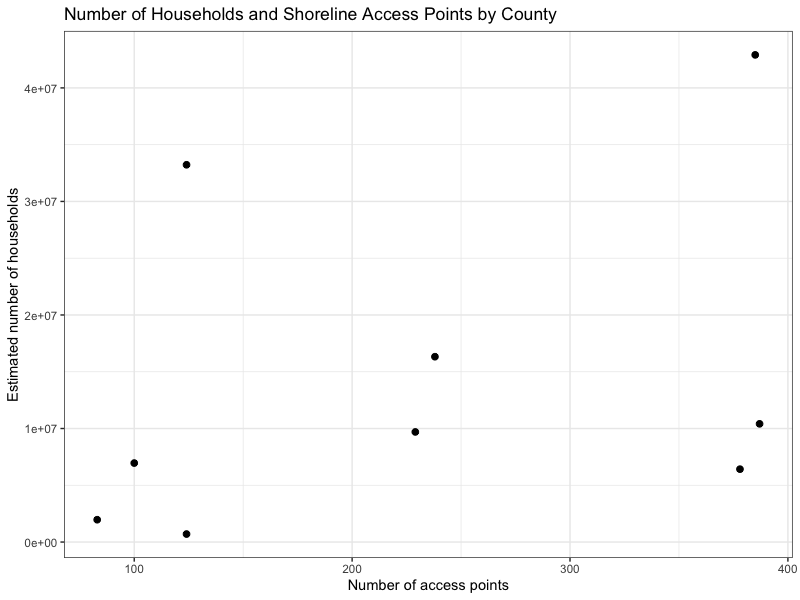

In [11]:
ggplot(df, aes(x = num_pts, y = num_households)) +
  geom_point(size = 2) +
  labs(
    title = "Number of Households and Shoreline Access Points by County",
    x = "Number of access points",
    y = "Estimated number of households"
  ) +
  theme_bw()